<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 3 / NOTE 4*

# 📝 Assignment
---

# Interpreting ML Model

### 1) PDP를 만들어 모델을 설명하세요
- 한 특성에 대한 PDP를 만들고 모델을 설명하세요
- 두 특성간 관계에 대한 PDP를 만들고 모델을 설명하세요
- **Boston 데이터의 train 데이터를 사용해 PDP plots을 그린 후, 집값에 대해 양의 선형관계를 나타내는 특성을 고르세요.**
    - 1) LSTAT
    - 2) B
    - 3) TAX
    - 4) AGE


In [2]:
# ! pip install category_encoders
# ! pip install shap
# ! pip install pdpbox

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, roc_curve, classification_report, plot_confusion_matrix, roc_auc_score
from scipy.stats import randint, uniform

     |████████████████████████████████| 82 kB 364 kB/s 
     |████████████████████████████████| 371 kB 9.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509237 sha256=48de9cb2441117d1a9a0dd30d3ff8c2a733a913a56d0c560f36a6e247ad7eff2
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap
     |████████████████████████████████| 34.0 MB 43 kB/s 
     |████████████████████████████████| 13.1 MB 6.9 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=10ba5fdb3243142211af3465fec50366afa0c86ae8c79883bf87cb50eb22689d
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: ma

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 자료 출처 : 서울 열린데이터 광장 - 서울특별시 부동산 실거래가 정보
# https://data.seoul.go.kr/dataList/OA-15548/S/1/datasetView.do

df = pd.read_csv('https://docs.google.com/uc?export=download&id=1WyeDe2Ry4ohJobcbnQJXHxFEAtcg-CC_', encoding='cp949')

# 서울 부동산 물건금액 예측해보기
# 1) 가격 예측
# 2) 고가 주택(9억 초과)과 고가 주택 아닌 것으로 분류(물건가격으로 특성 만든 후 물건금액 특성 제거를 통해 정보 누수 예방하기)

In [ ]:
# 지번코드 자릿수가 19가 아닌 것을 제거
# 제거될 데이터는 전체의 10% 미만임
df = df[df['지번코드'].map(str).apply(len) == 19]

# 층정보 -1인 경우는 실제로 반지하일 수도 있겠으나, 데이터의 수가 전체의 약 3% 수준이라 영향이 크지 않다고 판단함
# 층정보 -2, -3인 경우는 부호 표기가 반대로 된 것으로 판단함
# 따라서 음수인 층정보는 양수로 바꾸는 것으로 처리
tmp_idx = df[df['층정보'] < 0]['층정보'].index
df.loc[tmp_idx, ['층정보']] = df[df['층정보'] < 0]['층정보'].mul(-1)

# 건축년도가 nan 또는 0인 데이터가 있다
# 전체 데이터의 약 1% 이므로 제거
df = df[(df['건축년도'] != 0) & ~(df['건축년도'].isna())]
len(df[(df['건축년도'] == 0) | (df['건축년도'].isna())])

# 층정보와 건물명이 없는 데이터는 모두 단독주택이므로 층정보는 2로 대체
# (건축법 상 단독주택(단독주택/다중주택/다가구주택)은 3개 층 이하로 제한되어 있음 -> 1~3의 중간값인 2로 대체)
# 참고 : https://justdim.tistory.com/146
df['층정보'] = df['층정보'].fillna(2)

In [ ]:
# 불필요한 컬럼 제거

# 대지권면적은 결측치가 대다수이므로 제거
# 참고 : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ctrfindit&logNo=221272287733
df = df.drop('대지권면적', axis=1)

# 실제로 건물명이 가격에 영향을 줄 것이라는 심증이 있으나(브랜드 가치 등의 이유),
# 현재로서는 처리할 방법을 모르기 때문에 건물명 컬럼은 제거
df = df.drop('건물명', axis=1)

# 실거래가아이디는 거래 자체의 고유 번호이므로 가격과 관련없다고 판단하여 컬럼 제거
df = df.drop('실거래가아이디', axis=1)

# 법정동코드는 지번코드에서 '필지구분(1)+본번(4)+부번(4)'을 제외한 것으로서, 지번코드가 법정동코드의 정보를 반영한다고 봄
# 따라서 법정동코드 컬럼 제거. 시군구코드도 지번코드에 포함되므로 컬럼 제거.
# 자치구명, 법정동명 또한 지번코드가 모두 반영하므로 컬럼 제거
# 참고 : https://zelkun.tistory.com/entry/%EB%B2%95%EC%A0%95%EB%8F%99%ED%96%89%EC%A0%95%EB%8F%99-%EC%B0%A8%EC%9D%B4%EC%A0%90-%EB%B0%8F-%EA%B5%AC%EB%B3%84%ED%98%84%ED%99%A9
# df = df.drop(['법정동코드', '시군구코드', '자치구명', '법정동명'], axis=1)

# 모든 데이터가 2020년에 신고된 거래 데이터이므로 신고년도는 불필요함. 컬럼 제거
df = df.drop('신고년도', axis=1)

# 업무구분 모두 '신고'이고, 업무구분코드도 모두 이에 해당하는 '4'임
# 그 이전에 컬럼 자체도 불필요하다고 판단함. 따라서 컬럼 제거
df = df.drop(['업무구분', '업무구분코드'], axis=1)

# 물건번호는 경매에서 각 물건에 붙는 번호를 의미함
# 예를 들어 한 사건에 한 개 물건이면 물건번호는 1임.
# 일종의 고유 번호이므로 물건가격과 상관없다고 판단하여 컬럼 제거
# 참고 : https://m.blog.naver.com/maestron1/221534254422
df = df.drop('물건번호', axis=1)

# 관리구분코드는 공공기관 내부적으로 사용하는 것으로 추정
# 자세한 내용은 확인할 수 없었음
# 명칭으로 보아 물건가격과는 관련이 없다고 보고 컬럼 제거
df = df.drop('관리구분코드', axis=1)

# 건물주용도코드가 건물주용도를 반영하고 있으므로 건물주용도 컬럼 제거 -> 결과 해석의 편의를 위해 건물주용도코드를 제거
# df = df.drop('건물주용도', axis=1)
df = df.drop('건물주용도코드', axis=1)

# # 위 과정 한꺼번에 정리한 결과 가져오기
# df = df[['지번코드',	'건물면적',	'층정보',	'건물주용도코드',	'물건금액',	'건축년도']]

In [ ]:
# 건축년도를 그대로 사용하기보다는 몇 년이나 오래 되었는지 나타내는 컬럼이 필요하지 않을까?
df['연식'] = (2020 - df['건축년도']).astype(int)

# 건물면적을 통해 집을 소형/중형/대형으로 구분하면 어떨까?
# 기준 : 60㎡ 이하 = 소형 / 60㎡ 초과~85㎡ 이하 = 중형 / 85㎡ 초과 = 대형
# 참고 : https://www.hani.co.kr/arti/economy/property/689578.html
df['주택규모'] = df['건물면적'].apply(lambda x: 'S' if x <= 60 else 'L' if x > 85 else 'M')

# 물건금액 9억 초과를 기준으로 고가주택과 고가주택이 아닌 물건으로 분류 예측은 어떨까?
# 2020년 기준 고가주택 기준 : 9억
# 참고 : https://m.post.naver.com/viewer/postView.nhn?volumeNo=32576102&memberNo=36833282
df['고가주택여부'] = df['물건금액'].apply(lambda x: 1 if x > 900000000 else 0)

# 층정보, 건축년도는 int로 형변환하여 소수점 제거
df[['층정보', '건축년도']] = df[['층정보', '건축년도']].astype(int)

# 층정보, 건축년도, 건물주용도코드는 연속적인 수치형이 아닌 범주형으로 간주하여 컬럼 형변환
# df[['층정보', '건축년도', '건물주용도코드']] = df[['층정보', '건축년도', '건물주용도코드']].astype(str)

# 시군구코드, 법정동코드는 연속적인 수치형이 아닌 범주형으로 간주하여 컬럼 형변환
df[['시군구코드', '법정동코드']] = df[['시군구코드', '법정동코드']].astype(str)

# 컬럼명 변경하기
# df.columns = ['addr_code', 'size', 'floor', 'type', 'price', 'built_year', 'years', 'size_grade', 'is_high_price']
df.columns = ['addr_code', 'city_code', 'city_name', 'area_code', 'area_name', 'size', 'floor', 'type', 'price', 'built_year', 'years', 'size_grade', 'is_high_price']

In [ ]:
df.head()

In [ ]:
df.dtypes

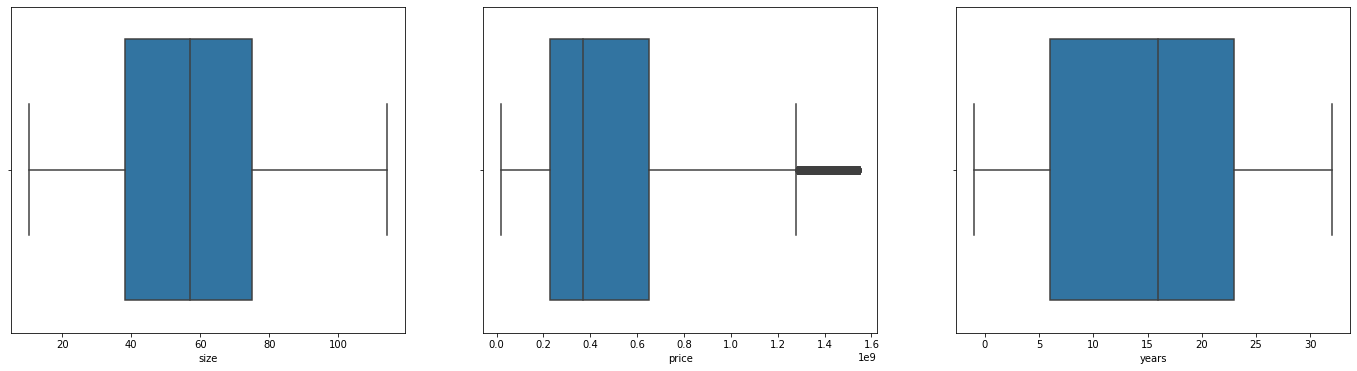

In [ ]:
# 수치형 컬럼(타겟 포함)의 이상치 확인하기
col_list = ['size', 'price', 'years']

def checkOutlier(df, cols):
  fig, axes = plt.subplots(1, 3, figsize=(24, 6))
  for i, col in enumerate(col_list):
    sns.boxplot(x=col, data=df, ax=axes[i])

# 수치형 컬럼 전체적으로 이상치로 보이는 값들이 존재함
# 각각에 대하여 상위 5%를 제거
target = 'price'
df = df[df[target] < np.percentile(df[target], 95)]
df = df[df['size'] < np.percentile(df['size'], 95)]
df = df[df['years'] < np.percentile(df['years'], 95)]
checkOutlier(df, col_list)

# 인덱스 재정렬
df = df.reset_index(drop=True)

470946234.08997595


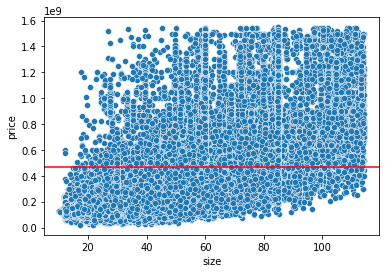

In [ ]:
# 가장 상관관계가 높은 size와 타겟(price)의 관계 시각화해보기
baseline = df.price.mean() # 기준 모델 : 타겟(price)의 평균값
print(baseline)

sns.scatterplot(x='size', y='price', data=df)
plt.axhline(baseline, color='red'); # 기준 모델 시각화

# 기준 모델의 의미 : 2020년 서울 부동산 물건가격(실거래가)의 평균

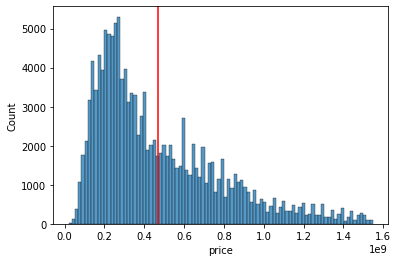

In [ ]:
# 타겟(price)의 분포 확인해보기
sns.histplot(df.price, kde=False);
plt.axvline(baseline, color='red'); # 기준 모델 시각화
# price는 right-skewed이므로 로그 변환이 필요

In [ ]:
# 기준 성능(회귀)
errors = baseline - df.price
baseline_mae = errors.abs().mean()
baseline_mae

254535177.4446938

0    0.895478
1    0.104522
Name: is_high_price, dtype: float64

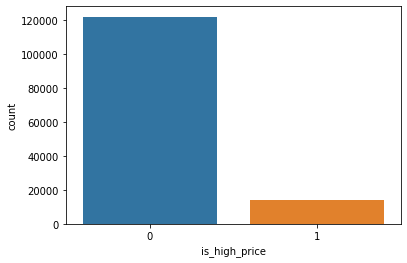

In [ ]:
# 타겟(is_high_price)의 클래스 비율 확인해보기 - 기준 성능(분류)
sns.countplot(x=df.is_high_price);
df.is_high_price.value_counts(normalize=True)
# is_high_price는 클래스 비율이 불균형하므로 학습 시 class_weight 관련 설정이 필요

In [ ]:
# 물건가격 예측은 회귀, 고가주택여부는 분류
# 회귀 : 릿지 회귀, 결정 트리, 랜덤 포레스트
# 분류 : 로지스틱 회귀, 결정 트리, 랜덤 포레스트

# 훈련 / 검증 / 테스트 셋으로 분리
train, test = train_test_split(df, test_size=0.30, random_state=2)
train, val = train_test_split(train, test_size=0.30, random_state=2)

train.shape, val.shape, test.shape

((66831, 13), (28643, 13), (40918, 13))

In [ ]:
# 특성과 타겟 분리하기
target_cl = 'is_high_price' # 분류 문제 타겟
targets = [target, target_cl]
features = train.drop(columns=targets).columns

X_train = train[features]
y_train = train[target]
y_train_cl = train[target_cl]
X_val = val[features]
y_val = val[target]
y_val_cl = val[target_cl]
X_test = test[features]
y_test = test[target]
y_test_cl = test[target_cl]

X_train.head()

,addr_code,city_code,city_name,area_code,area_name,size,floor,type,built_year,years,size_grade
127762,1121510500107620000,11215,광진구,1121510500,자양동,84.60,1,아파트,1996,24,M
44709,1120010700103040007,11200,성동구,1120010700,행당동,57.31,4,연립주택,1994,26,S
75903,1135010600105120000,11350,노원구,1135010600,중계동,59.26,9,아파트,1991,29,S
55311,1129013600100901817,11290,성북구,1129013600,하월곡동,26.25,7,연립주택,2019,1,S
88322,1138010700100970003,11380,은평구,1138010700,응암동,84.84,4,아파트,2004,16,M


In [ ]:
# 'addr_code', 'city_code', 'city_name', 'area_code', 'area_name', 'type' : TargetEncoder
# 범주 간의 순서가 없는 특성
tge_col = ['addr_code', 'city_code', 'city_name', 'area_code', 'area_name', 'type']
# size_grade : OrdinalEncoder
# 범주 간의 순서가 있는 특성(소/중/대)
ord_col = ['size_grade']

In [ ]:
eval_set = [(X_train, y_train), 
            (X_val, y_val)]

In [ ]:
# 1. 회귀
pipe_xgb = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    XGBRegressor(n_estimators=1000
              , random_state=2
              , n_jobs=-1
              , eval_set=eval_set
              , eval_metric='mae'
              , early_stopping_rounds=50) # 50 rounds 동안 스코어의 개선이 없으면 멈춤
)

dists_xgb = {
    'xgbregressor__max_depth': [5, 10, 15, 20, None],
    'xgbregressor__learning_rate': uniform(0.01, 0.2),
    'xgbregressor__subsample': uniform(0.5, 1),
    'xgbregressor__colsample_bytree': uniform(0.5, 1),
    'xgbregressor__max_features': uniform(0, 1)
}

clf_xgb = RandomizedSearchCV(
    pipe_xgb, 
    param_distributions=dists_xgb, 
    n_iter=50, 
    cv=3, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf_xgb.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 40.5min finished


[11:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
tt_xgb = TransformedTargetRegressor(regressor=clf_xgb.best_estimator_,
                                func=np.log1p, inverse_func=np.expm1)

tt_xgb.fit(X_train, y_train);

y_pred_xgb_train = tt_xgb.predict(X_train)
mae_xgb_train = mean_absolute_error(y_train, y_pred_xgb_train)
r2_xgb_train = r2_score(y_train, y_pred_xgb_train)
print(f'Train MAE: {mae_xgb_train:,.0f}')
print(f'R2 Score: {r2_xgb_train:,.4f}\n')

y_pred_xgb_val = tt_xgb.predict(X_val)
mae_xgb_val = mean_absolute_error(y_val, y_pred_xgb_val)
r2_xgb_val = r2_score(y_val, y_pred_xgb_val)
print(f'Val MAE: {mae_xgb_val:,.0f}')
print(f'R2 Score: {r2_xgb_val:,.4f}\n')

y_pred_xgb = tt_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'Test MAE: {mae_xgb:,.0f}')
print(f'R2 Score: {r2_xgb:,.4f}')

[11:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train MAE: 34,770,825
R2 Score: 0.9696

Val MAE: 47,867,611
R2 Score: 0.9378

Test MAE: 47,797,654
R2 Score: 0.9396


In [ ]:
# 2. 분류

pipe_xgb_cl = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    XGBClassifier(n_estimators=1000
              , random_state=2
              , n_jobs=-1
              , eval_set=eval_set
              , eval_metric='auc'
              , early_stopping_rounds=50) # 50 rounds 동안 스코어의 개선이 없으면 멈춤
)

dists_xgb_cl = {
    'xgbclassifier__max_depth': [5, 10, 15, 20, None],
    'xgbclassifier__learning_rate': uniform(0.01, 0.2),
    'xgbclassifier__subsample': uniform(0.5, 1),
    'xgbclassifier__colsample_bytree': uniform(0.5, 1),
    'xgbclassifier__max_features': uniform(0, 1)
}

# 과적합 줄이기 및 최적화
clf_xgb_cl = RandomizedSearchCV(
    pipe_xgb_cl, 
    param_distributions=dists_xgb_cl, 
    n_iter=30, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf_xgb_cl.fit(X_train, y_train_cl);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 14.6min finished


In [ ]:
pipe_xgb_cl = clf_xgb_cl.best_estimator_

y_pred_xgb_cl_train = pipe_xgb_cl.predict(X_train)
f1_rf_cl = f1_score(y_train_cl, y_pred_xgb_cl_train)
print(f'Train F1: {f1_rf_cl}')

y_pred_xgb_cl_val = pipe_xgb_cl.predict(X_val)
f1_rf_cl = f1_score(y_val_cl, y_pred_xgb_cl_val)
print(f'Val F1: {f1_rf_cl}')

y_pred_xgb_cl = pipe_xgb_cl.predict(X_test)
f1_rf_cl = f1_score(y_test_cl, y_pred_xgb_cl)
print(f'Test F1: {f1_rf_cl}')

Train F1: 0.9171910031098576
Val F1: 0.850958126330731
Test F1: 0.8625090296171443


In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

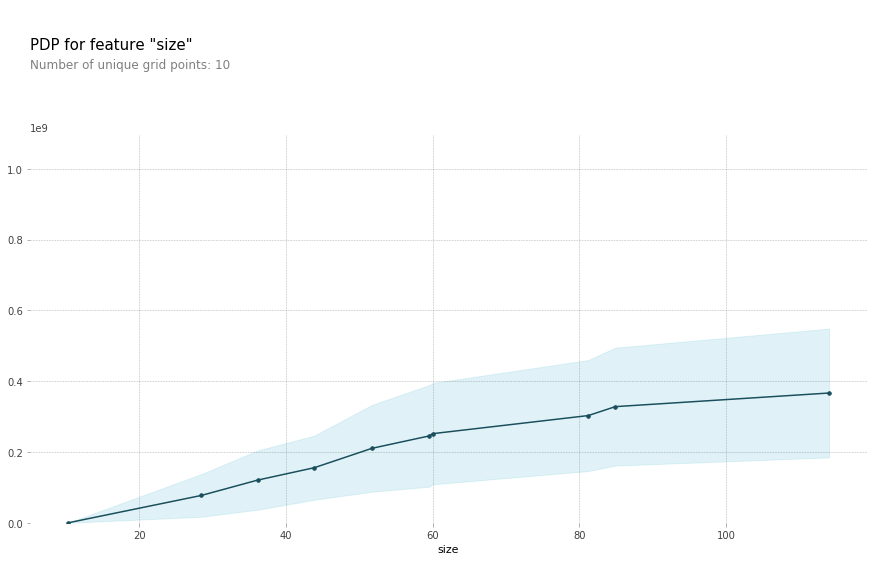

In [ ]:
# 1D PDP (회귀 모델 기준)
feature = 'size'

isolated = pdp_isolate(
    model=tt_xgb, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);
# 부동산 물건의 건물면적이 커질수록 물건가격이 올라간다

In [ ]:
# 2D PDP
features = ['size', 'years']

interaction = pdp_interact(
    model=tt_xgb, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

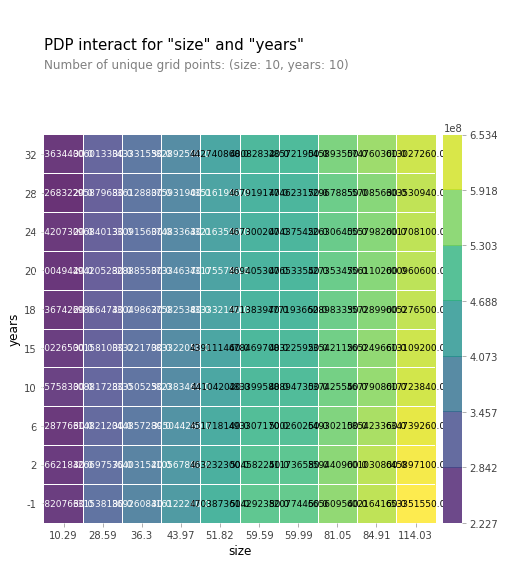

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);
# 면적(size)이 크고 연식(years)이 작을수록 타겟값(물건가격)이 큼
# 다만 연식보다는 면적의 영향이 더 크다고 보여짐

In [3]:
import sklearn
import xgboost
import shap
from sklearn.model_selection import train_test_split

shap.initjs();

df, target = shap.datasets.boston()
X_train,X_test,y_train,y_test = train_test_split(df, target, test_size=0.2, random_state=2)

model = xgboost.XGBRegressor().fit(X_train, y_train)

[04:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


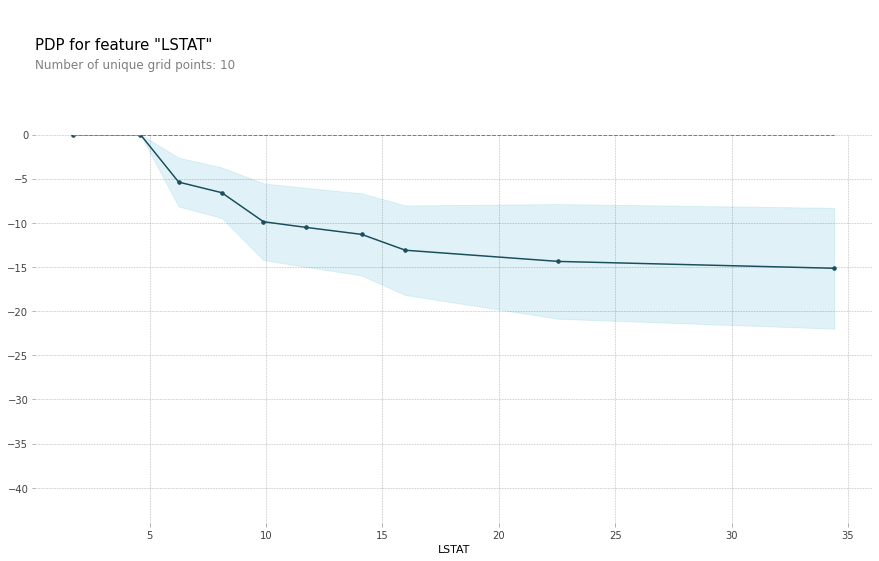

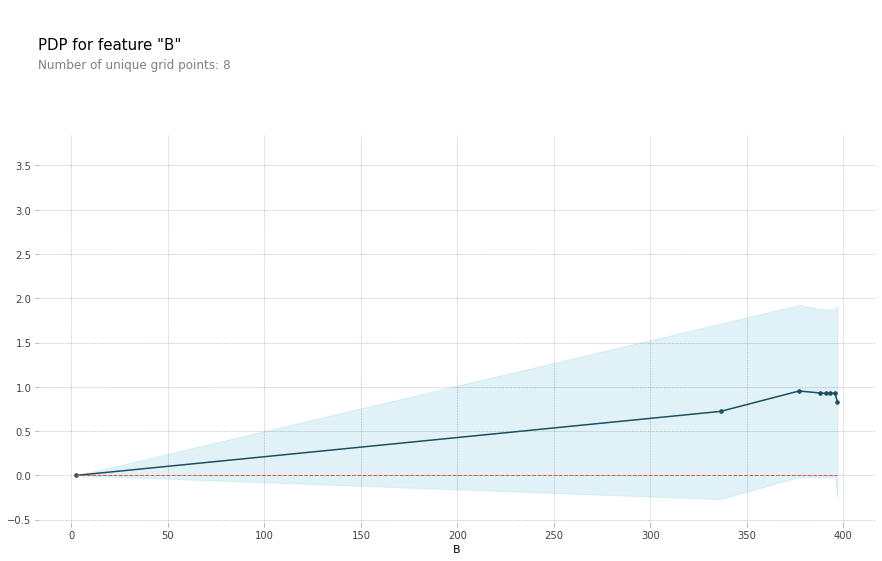

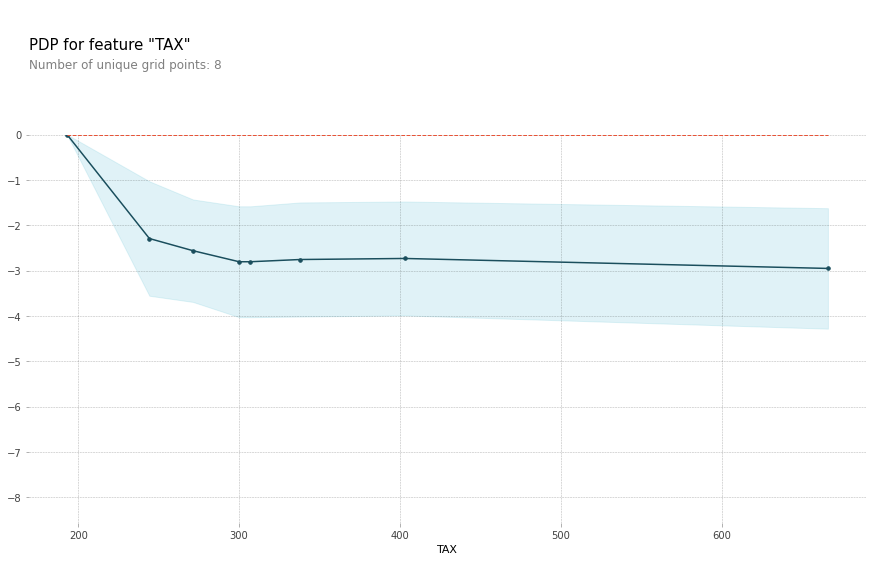

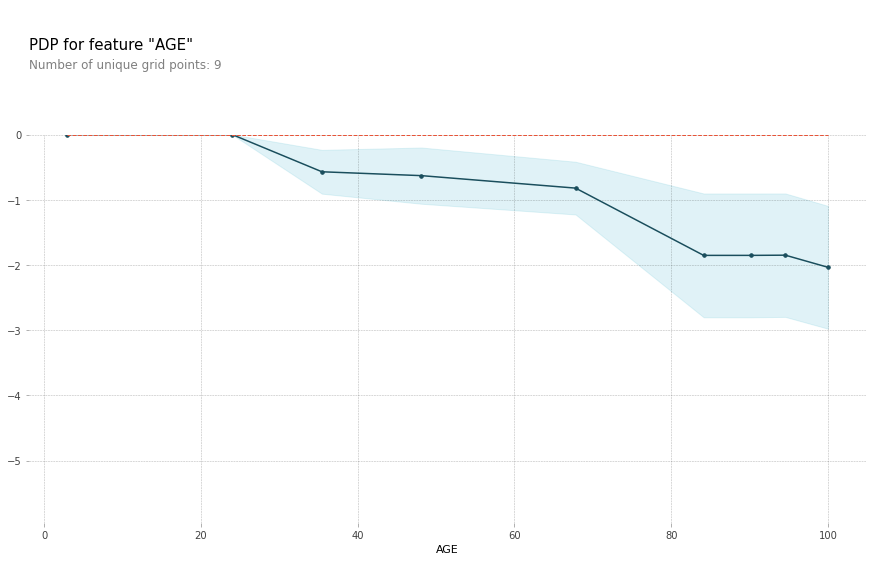

In [4]:
from pdpbox.pdp import pdp_isolate, pdp_plot

features = ['LSTAT', 'B', 'TAX', 'AGE']

for feature in features:
  isolated = pdp_isolate(
      model=model, 
      dataset=X_test, 
      model_features=X_test.columns, 
      feature=feature
  )
  pdp_plot(isolated, feature_name=feature);

# 양의 선형관계를 나타내는 특성 : B

### 2) SHAP 라이브러리를 사용해 최소 3개 이상 시각화를 하고 분석하세요
- 본인 포트폴리오 데이터를 사용해서 SHAP 시각화를 수행하세요
- **SHAP 라이브러리를 사용해 다음 문항 중 설명이 올바른 항목을 선택하세요.**
    - 1) force_plot을 그려보면 CRIM은 항상 가격을 낮추는 영향을 준다.
    - 2) SHAP의 summary_plot을 사용하면 permutation importance를 구할 수 있다.
    - 3) SHAP summary_plot을 그려보면 (조건: X_train, plot_type='bar') LSTAT이 가장 영향력이 큰 특성으로 보인다.
    - 4) 모델의 feature importance(model.feature_importances_)를 구하면 가장 영향력이 큰 특성이 LSTAT임을 알 수있다.


In [ ]:
# SHAP (분류 모델)
model = pipe_xgb_cl.named_steps['xgbclassifier']
encoder = make_pipeline(TargetEncoder(cols=tge_col), OrdinalEncoder(cols=ord_col))
X_test_encoded = encoder.fit_transform(X_test, y_test)

shap.initjs()
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test_encoded.iloc[:300])
shap.force_plot(explainer.expected_value, shap_values, X_test_encoded.iloc[:300])

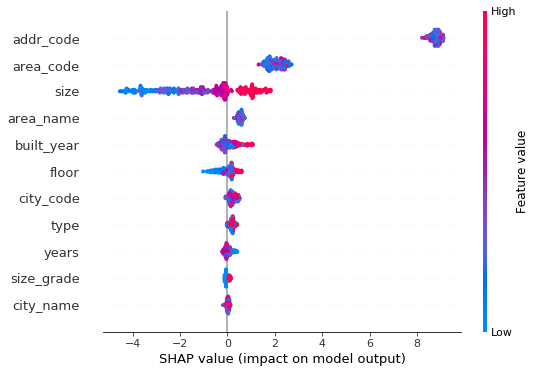

In [ ]:
shap_values = explainer.shap_values(X_test_encoded.iloc[:300])
shap.summary_plot(shap_values, X_test_encoded.iloc[:300])

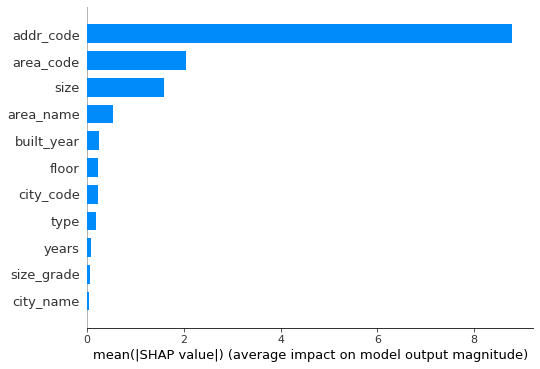

In [ ]:
shap.summary_plot(shap_values, X_test_encoded.iloc[:300], plot_type="bar")

In [5]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:300])
# 1) force_plot을 그려보면 CRIM은 항상 가격을 낮추는 영향을 준다. X

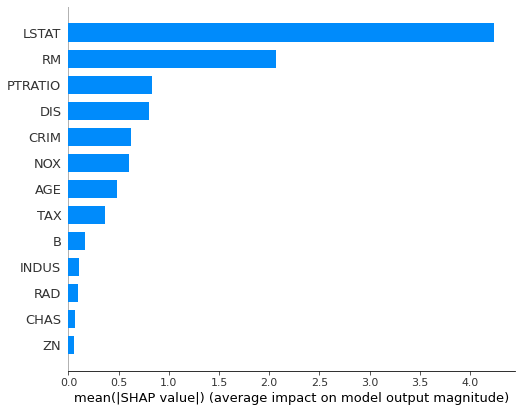

In [6]:
shap.summary_plot(shap_values, X_train, plot_type='bar')
# 2) SHAP의 summary_plot을 사용하면 permutation importance를 구할 수 있다. X -> permutation importance와 다른 결과를 보여준다
# 3) SHAP summary_plot을 그려보면 (조건: X_train, plot_type='bar') LSTAT이 가장 영향력이 큰 특성으로 보인다. O

In [ ]:
# !pip install eli5

In [10]:
# permutation importance
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error', 
    n_iter=5,
    random_state=2
)

permuter.fit(X_train, y_train);

import pandas as pd
feature_names = X_train.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
4.1290 ± 0.4680,LSTAT
2.0802 ± 0.2066,RM
1.1377 ± 0.0646,DIS
0.6329 ± 0.1098,NOX
0.4814 ± 0.0135,CRIM
0.4695 ± 0.0622,AGE
0.4437 ± 0.0774,PTRATIO
0.2984 ± 0.0374,TAX
0.1873 ± 0.0448,B
0.0593 ± 0.0121,INDUS


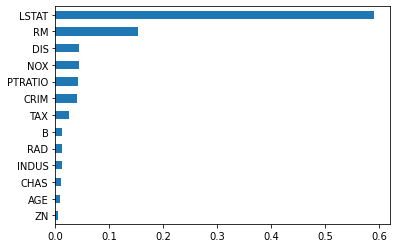

In [7]:
importances = pd.Series(model.feature_importances_, X_train.columns)
importances.sort_values().plot.barh();
# 4) 모델의 feature importance(model.feature_importances_)를 구하면 가장 영향력이 큰 특성이 LSTAT임을 알 수 있다. O

## 🔥 도전과제

### 3) 지속적으로 포트폴리오 프로젝트를 수행하세요
- 지속적으로 데이터를 랭글링 하고 추가적인 시각화 결과를 만드세요